# IFT603 - Devoir 4

* Classifieur linéaire avec un réseau de neurones à une couche
* Fonction de perte: entropie-croisée
* Descente de gradient
* Recherche d'hyperparamètres
* Visualisation des résultats

# Configuration

In [11]:
'''
 Imporation des bibliothèques python générales
'''
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.datasets import make_classification

'''
 Imporation des bibliothèques spécifiques au devoir
'''
import utils
from linear_classifier import LinearClassifier
from two_layer_classifier import TwoLayerClassifier

%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1ère partie du devoir : la classification linéaire par régression logistique

**Préparation des données**

Nous utilisons une fonction bien connue de sklearn pour générer un jeu de données nommée [make_classification](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html).  Cette base de données comprend 1000 éléments distribués dans 3 classes.

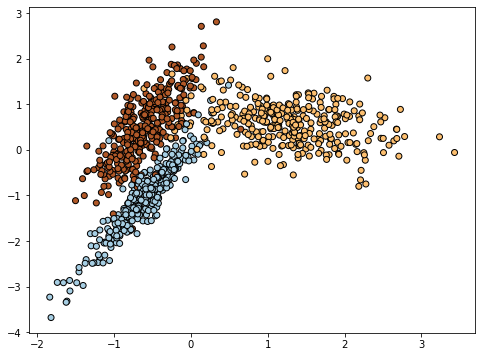

In [12]:
# Générer des données
X_, y_ = make_classification(1000,n_features=2, n_redundant=0, n_informative=2,n_clusters_per_class=1, n_classes=3,random_state=6)

# Centrer et réduire les données (moyenne = 0, écart-type = 1)
mean = np.mean(X_, axis=0)
std = np.std(X_, axis=0)
X_ = (X_ - mean) / std

# Afficher
plt.figure(figsize=(8, 6))
plt.scatter(X_[:, 0], X_[:, 1], c=y_, edgecolors='k', cmap=plt.cm.Paired)
plt.show()

Séparons le jeu de données en trois parties: l'ensemble **d'entraînement**, de **validation** et de **test** (_train_, _val_ et _test_).

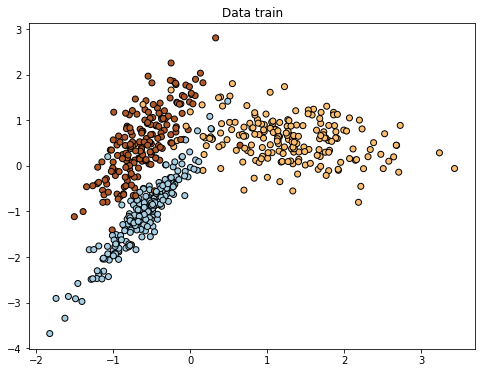

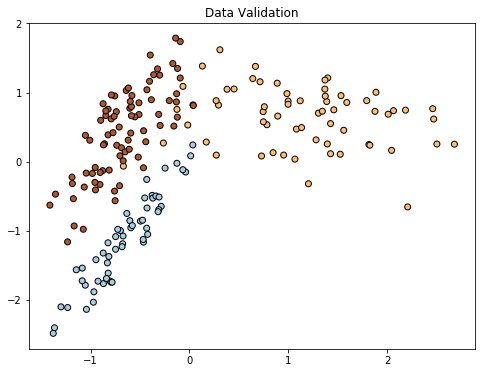

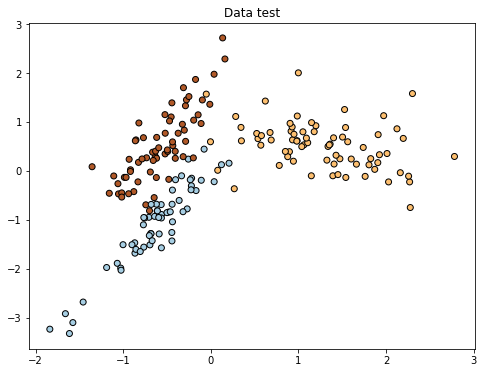

In [13]:
num_val = 200
num_test = 200
num_train = 600
np.random.seed(1)
idx = np.random.permutation(len(X_))

train_idx = idx[:num_train]
val_idx = idx[num_train:num_train + num_val]
test_idx = idx[-num_test:]

X_train = X_[train_idx]
y_train = y_[train_idx]
X_val = X_[val_idx]
y_val = y_[val_idx]
X_test = X_[test_idx]
y_test = y_[test_idx]

# Afficher
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
plt.title('Data train')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, edgecolors='k', cmap=plt.cm.Paired)
plt.title('Data Validation')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k', cmap=plt.cm.Paired)
plt.title('Data test')
plt.show()

Vérifions que les données sont valides en entraînant un SVM de la librairie `scikit-learn`.

In [14]:
accu = utils.test_sklearn_svm(X_train, y_train, X_test, y_test)
print('Test accuracy: {:.3f}'.format(accu))
if accu < 0.7:
    print('ERREUR: L\'accuracy est trop faible. Il y a un problème avec les données. Vous pouvez essayer de refaire le mélange (case ci-haut).')

Test accuracy: 0.950


# Implémenter un classifieur logistique linéaire

Dans `linear_classifer.py`, implémenter la `cross_entropy_loss` (entropie croisée) ainsi que les méthodes avec l'indicatif TODO

Une fois fait, vérifier votre implémentation avec les cases qui suivent.

Commençons par quelques **Sanity Checks**

In [19]:
# En premier, vérifier la prédiction du modèle, la "forward pass"
# 1. Générer le modèle avec des poids W aléatoires
model = LinearClassifier(X_train, y_train, X_val, y_val, num_classes=3, bias=True)

# 2. Appeler la fonction qui calcule l'accuracy et la loss moyenne pour l'ensemble des données d'entraînement
_, loss = model.global_accuracy_and_cross_entropy_loss(X_train,y_train)

# 3. Comparer au résultat attendu
loss_attendu = -np.log(1.0/3.0) # résultat aléatoire attendu soit -log(1/nb_classes)
print('Sortie: {}  Attendu: {}'.format(loss, loss_attendu))
if abs(loss - loss_attendu) > 0.05:
    print('ERREUR: la sortie de la fonction est incorrecte.')
else:
    print('SUCCÈS')

1.0
Sortie: 1.0574162425336746  Attendu: 1.0986122886681098
SUCCÈS


In [21]:
# Vérification: Vous devez pouvoir faire du surapprentissage sur quelques échantillons.
# Si l'accuracy reste faible, votre implémentation a un bogue.
n_check = 5
X_check = X_train[:n_check]
y_check = y_train[:n_check]
model = LinearClassifier(X_check, y_check, X_val, y_val, num_classes=3, bias=True)
loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = model.train(num_epochs=10, lr=1.0, l2_reg=0.0)
accu_train_finale = accu_train_curve[-1]
print('Accuracy d\'entraînement, devrait être 1.0: {:.3f}'.format(accu_train_finale))
if accu_train_finale < 0.9999:
    print('ATTENTION: L\'accuracy n\'est pas 100%.')
    utils.plot_curves(loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve)
else:
    print('SUCCÈS')

[[ 0.03337599 -0.0709592   0.03758321]
 [ 0.03551006 -0.07549636  0.03998629]
 [ 0.05238391 -0.11137109  0.05898718]]
[[ 0.02093658 -0.05274492  0.03180834]
 [ 0.05019018 -0.12644265  0.07625248]
 [ 0.0785046  -0.19777436  0.11926976]]
[[ 0.20672773 -0.05657767 -0.15015006]
 [ 0.43771109 -0.11979366 -0.31791743]
 [-0.74385079  0.2035786   0.54027219]]
[[-0.16330231 -0.10300201  0.26630432]
 [-0.06379882 -0.04024075  0.10403956]
 [ 0.20040782  0.12640611 -0.32681393]]
[[ 0.08112887 -0.12980994  0.04868107]
 [ 0.00286479 -0.0045838   0.00171901]
 [ 0.06089164 -0.09742943  0.0365378 ]]
[[-0.15965322 -0.09112343  0.25077665]
 [-0.09037331 -0.05158133  0.14195465]
 [ 0.21095158  0.1204024  -0.33135398]]
[[-0.05741944 -0.34378887  0.40120831]
 [ 0.0944523   0.56551672 -0.65996902]
 [ 0.09879322  0.59150719 -0.69030041]]
[[-0.09651913 -0.15726245  0.25378158]
 [ 0.01185907  0.01932245 -0.03118152]
 [ 0.18654012  0.30393722 -0.49047735]]
[[ 0.01958434 -0.02648545  0.00690112]
 [ 0.00699405 -0.

[[-0.04500753 -0.29338833  0.33839585]
 [ 0.05769343  0.37608326 -0.43377669]
 [ 0.07469718  0.48692478 -0.56162196]]
[[ 0.4422747  -0.02059016 -0.42168454]
 [ 0.71666925 -0.03336464 -0.68330462]
 [-0.74663658  0.03475977  0.71187681]]
[[ 0.01723804 -0.03145656  0.01421852]
 [ 0.016716   -0.03050393  0.01378793]
 [ 0.0231191  -0.04218853  0.01906942]]
[[ 7.97846538e-01 -1.23408674e-03 -7.96612451e-01]
 [ 1.64161392e+00 -2.53920256e-03 -1.63907472e+00]
 [-7.66413744e-01  1.18546737e-03  7.65228277e-01]]
[[ 0.02719816 -0.03963647  0.01243831]
 [ 0.01180931 -0.01720997  0.00540066]
 [ 0.02514081 -0.03663825  0.01149744]]
[[ 0.00835643 -0.00945566  0.00109923]
 [ 0.00285183 -0.00322696  0.00037514]
 [ 0.0041584  -0.0047054   0.00054701]]
[[-0.00198221  0.00810579 -0.00612358]
 [ 0.03301136 -0.13499229  0.10198093]
 [ 0.03031625 -0.12397126  0.09365502]]
[[-0.08348311 -0.16649997  0.24998308]
 [ 0.03918127  0.07814371 -0.11732497]
 [ 0.10145506  0.2023435  -0.30379855]]
[[ 0.32588229 -0.015

 [ 0.03166626  0.59608888 -0.62775514]]
[[ 0.39894436 -0.01401279 -0.38493157]
 [ 0.64125813 -0.02252398 -0.61873415]
 [-0.69090692  0.02426788  0.66663905]]
[[ 0.03839599 -0.04176872  0.00337273]
 [ 0.00266054 -0.00289424  0.0002337 ]
 [ 0.02518353 -0.02739567  0.00221214]]
[[ 9.12336305e-03 -9.26140649e-03  1.38043445e-04]
 [ 9.24053152e-04 -9.38034781e-04  1.39816293e-05]
 [ 3.64631637e-03 -3.70148792e-03  5.51715492e-05]]
[[-0.06395645 -0.14671839  0.21067485]
 [ 0.03197109  0.07334283 -0.10531392]
 [ 0.10326763  0.23689963 -0.34016726]]
[[ 0.00516807 -0.00777593  0.00260786]
 [ 0.00515481 -0.00775599  0.00260117]
 [ 0.00524018 -0.00788443  0.00264425]]
[[ 0.00553537 -0.01571883  0.01018346]
 [ 0.01806261 -0.05129251  0.0332299 ]
 [ 0.02048017 -0.05815766  0.03767749]]
[[ 0.01007475 -0.01656094  0.00648619]
 [ 0.01071893 -0.01761985  0.00690092]
 [ 0.0158124  -0.02599254  0.01018014]]
[[ 0.00836975 -0.0206029   0.01223315]
 [ 0.02006437 -0.04939026  0.02932589]
 [ 0.03138354 -0.077

 [ 0.01965667 -0.08875541  0.06909875]]
[[ 0.4406912  -0.00144389 -0.43924731]
 [ 0.7446205  -0.0024397  -0.7421808 ]
 [-0.5409973   0.00177254  0.53922476]]
[[-0.00183205 -0.11440656  0.11623861]
 [ 0.01392783  0.86975462 -0.88368245]
 [ 0.0141872   0.88595135 -0.90013855]]
[[ 0.51171418 -0.00242777 -0.50928641]
 [ 0.73206222 -0.00347319 -0.72858903]
 [-0.6215375   0.00294882  0.61858868]]
[[ 0.00245787 -0.0026991   0.00024122]
 [ 0.00153955 -0.00169064  0.0001511 ]
 [ 0.00177073 -0.00194451  0.00017379]]
[[ 4.81917079e-03 -4.82473109e-03  5.56029864e-06]
 [ 4.51621655e-04 -4.52142730e-04  5.21075384e-07]
 [ 1.79882725e-03 -1.80090271e-03  2.07546425e-06]]
[[ 3.80684608e-01 -1.59578512e-04 -3.80525030e-01]
 [ 7.99216171e-01 -3.35022022e-04 -7.98881149e-01]
 [-3.92055949e-01  1.64345244e-04  3.91891604e-01]]
[[-0.00212985 -0.26226065  0.2643905 ]
 [ 0.00886834  1.09200857 -1.10087691]
 [ 0.00708736  0.87270709 -0.87979445]]
[[-0.02379721 -0.21495759  0.23875481]
 [ 0.02791761  0.252176

[[-0.08112932  0.62985188 -0.54872256]
 [-0.00815614  0.06332063 -0.05516449]
 [ 0.12148152 -0.94312839  0.82164687]]
[[ 1.60550978e-02 -1.64457364e-02  3.90638652e-04]
 [ 3.93069414e-03 -4.02633236e-03  9.56382252e-05]
 [ 1.25378614e-02 -1.28429217e-02  3.05060319e-04]]
[[ 0.01522756 -0.0288358   0.01360824]
 [ 0.02523483 -0.04778615  0.02255132]
 [ 0.08951603 -0.16951278  0.07999675]]
[[ 1.15926027e-02 -1.16343676e-02  4.17649238e-05]
 [ 1.57312429e-03 -1.57879182e-03  5.66752935e-06]
 [ 6.38786466e-03 -6.41087836e-03  2.30136999e-05]]
[[ 8.79875304e-04 -8.82583315e-04  2.70801054e-06]
 [ 2.99766790e-04 -3.00689389e-04  9.22598491e-07]
 [ 4.02783002e-04 -4.04022655e-04  1.23965363e-06]]
[[-0.03092436 -0.040357    0.07128136]
 [ 0.00926909  0.01209638 -0.02136547]
 [ 0.03600132  0.04698256 -0.08298388]]
[[ 0.11648494 -0.00225083 -0.11423411]
 [ 0.29286203 -0.00565896 -0.28720308]
 [-0.25063308  0.00484297  0.24579011]]
[[ 0.00113174 -0.00319656  0.00206482]
 [ 0.00263383 -0.00743918  

 [ 0.00156157 -0.00184549  0.00028392]]
[[-0.00235421 -0.16959119  0.1719454 ]
 [ 0.01022285  0.73642609 -0.74664894]
 [ 0.01158423  0.83449634 -0.84608057]]
[[ 1.71262242e-03 -1.75710007e-03  4.44776518e-05]
 [ 8.78884892e-04 -9.01709967e-04  2.28250756e-05]
 [ 1.17321108e-03 -1.20367996e-03  3.04688725e-05]]
[[ 1.92498117e-01 -2.02773163e-04 -1.92295344e-01]
 [ 3.79038502e-01 -3.99270586e-04 -3.78639231e-01]
 [-2.34351958e-01  2.46861053e-04  2.34105097e-01]]
[[ 2.03708649e-01 -5.60266249e-05 -2.03652622e-01]
 [ 3.98408902e-01 -1.09575643e-04 -3.98299327e-01]
 [-2.10963744e-01  5.80220165e-05  2.10905722e-01]]
[[-6.59130162e-01 -1.31685167e-04  6.59261847e-01]
 [-1.42291347e+00 -2.84278597e-04  1.42319775e+00]
 [ 8.21420042e-01  1.64108459e-04 -8.21584150e-01]]
[[ 1.12516394e-02 -1.12606205e-02  8.98116050e-06]
 [ 8.89527989e-04 -8.90238019e-04  7.10029301e-07]
 [ 5.50521708e-03 -5.50961139e-03  4.39431415e-06]]
[[-0.01298165 -0.17345006  0.18643171]
 [ 0.01469152  0.19629589 -0.2109

[[ 2.67994366e-04 -2.68079206e-04  8.48404422e-08]
 [ 8.33844532e-05 -8.34108507e-05  2.63974724e-08]
 [ 1.08941554e-04 -1.08976043e-04  3.44882238e-08]]
[[ 0.1572739  -0.0154581  -0.1418158 ]
 [ 0.22531179 -0.0221454  -0.20316639]
 [-0.4249071   0.04176318  0.38314392]]
[[ 0.08842386 -0.0026272  -0.08579666]
 [ 0.19772574 -0.00587471 -0.19185102]
 [-0.20461863  0.00607951  0.19853912]]
[[-0.03307807 -0.00048436  0.03356243]
 [-0.0115509  -0.00016914  0.01172004]
 [ 0.02442162  0.0003576  -0.02477922]]
[[ 1.77492274e-03 -1.82223920e-03  4.73164607e-05]
 [ 9.53275919e-04 -9.78688655e-04  2.54127358e-05]
 [ 1.36079681e-03 -1.39707337e-03  3.62765587e-05]]
[[ 0.21601004 -0.00126829 -0.21474176]
 [ 0.34732346 -0.00203928 -0.34528418]
 [-0.32183195  0.00188961  0.31994234]]
[[ 0.00032456 -0.00065452  0.00032996]
 [ 0.00052532 -0.00105938  0.00053406]
 [ 0.00045463 -0.00091682  0.00046219]]
[[ 0.14073695 -0.00414416 -0.13659279]
 [ 0.25236136 -0.00743107 -0.24493029]
 [-0.29671021  0.0087369

Lorsque ça fonctionne, maintenant testons l'effet du terme de régularisation l2_reg.  **Augmenter le terme l2_reg devrait augmenter la loss et, à la limite, faire décroire l'accuracy **

In [20]:
# Prenons encore un petit échantillon et testons différentes valeurs de l2_reg
n_check = 5
X_check = X_train[:n_check]
y_check = y_train[:n_check]
model = LinearClassifier(X_check, y_check, X_val, y_val, num_classes=3, bias=True)

for l2_r in np.arange(0,1,0.05):
    loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = model.train(num_epochs=10, lr=1.0, l2_reg=l2_r)
    print('l2_reg= {:.4f} >> Loss/accuracy d\'entraînement : {:.3f} {:.3f}'.format(l2_r,loss_train_curve[-1],accu_train_curve[-1]))


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
l2_reg= 0.0000 >> Loss/accuracy d'entraînement : 0.071 1.000
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
l2_reg= 0.0500 >> Loss/accuracy d'entraînement : 0.348 1.000
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
l2_reg= 0.1000 >> Loss/accuracy d'entraînement : 0.626 1.000
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
l2_reg= 0.1500 >> Loss/accuracy d'entraînement : 0.904 1.000
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
l2_reg= 0.2000 >> Loss/accuracy d'entraînement : 1.182 1.000
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
0.9999999999999999
1.0
l2_reg= 0.2500 >> Loss/accuracy d'entraînement : 1.459 1.000
1.0
1.0
0.999999999

# Vous pouvez maintenant essayer d'entraîner le modèle avec les données complètes

Normalement la loss devrait décroitre et l'accuracy augmenter en fonction des epochs

In [ ]:
# On instancie et entraîne notre modèle; cette fois-ci avec les données complètes.
model = LinearClassifier(X_train, y_train, X_val, y_val, num_classes=3, bias=True)
loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = model.train(lr=0.001,num_epochs=25, l2_reg=0.01)

# Illustration de la loss et de l'accuracy (le % de biens classés) à chaque itération     
utils.plot_curves(loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve)

print('[Training]   Loss: {:.3f}   Accuracy: {:.3f}'.format(loss_train_curve[-1], accu_train_curve[-1]))
print('[Validation] Loss: {:.3f}   Accuracy: {:.3f}'.format(loss_val_curve[-1], accu_val_curve[-1]))

# Rechercher de meilleurs hyperparamètres

Nous allons effectuer une recherche sur ces hyperparamètres:

* `learning rate`: La longueur des pas lors de la descente de gradient
* `L2 regularization`: La pénalité sur la taille des poids dans `W`

In [ ]:
lr_choices = [1e-2, 1e-1, 1.0, 10.0]
reg_choices = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
lr_decay = 0.995  # learning rate is multiplied by this factor after each step

best_accu = -1
best_params = None
best_model = None
best_curves = None

for lr, reg in itertools.product(lr_choices, reg_choices):
    params = (lr, reg)
    curves = model.train(num_epochs=25, lr=lr, l2_reg=reg, lr_decay=lr_decay)
    loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = curves
    
    val_accu = accu_val_curve[-1]
    if val_accu > best_accu:
        print('Best val accuracy: {:.3f} | lr: {:.0e} | l2_reg: {:.0e}'.format(val_accu, lr, reg))
        best_accu = val_accu
        best_params = params
        best_model = model
        best_curves = curves
        
model = best_model
utils.plot_curves(*best_curves)

# Vérifier la généralisation sur l'ensemble de test

In [ ]:
# On ré-entraîne le modèle avec les meilleurs hyper-paramètres
lr, reg = best_params
model.train(num_epochs=25, lr=lr, l2_reg=reg, lr_decay=lr_decay)

pred = model.predict(X_test)
accu = (pred == y_test).mean()
print('Test accuracy: {:.3f}'.format(accu))

# Tracer les frontières de décision

Nous allons créer une grille de points 2D qui recouvre les données, et nous allons prédire la classe pour chacun de ces points dans l'espace. Cela nous permettra de visualiser les frontières de décision apprises. 

In [ ]:
h = 0.01  # contrôle la résolution de la grille
x_min, x_max = X_[:, 0].min() - .5, X_[:, 0].max() + .5  # Limites de la grille
y_min, y_max = X_[:, 1].min() - .5, X_[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))  # Créer la grille

X_predict = np.c_[xx.ravel(), yy.ravel()]  # Convertir la grille en une liste de points
Z = model.predict(X_predict)  # Classifier chaque point de la grille
Z = Z.reshape(xx.shape)  # Remettre en 2D

plt.figure(figsize=(14, 8))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)  # Colorier les cases selon les prédictions

X_plot, y_plot = X_train, y_train
X_plot, y_plot = X_train, y_train
plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, edgecolors='k', cmap=plt.cm.Paired)  # Tracer les données

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Frontières de décision')
plt.show()

# 2e partie du devoir: la classification non-linéaire

Nous essaierons maintenant d'apprendre des frontières de décision **non-linéaires**.

In [1]:
#Choisissez le type de données que vous voulez 

# NOTE IMPORTANTE: on vous encourage à tester différentes bases de données.  Ceci dit, 
# votre solution sera testée avec Ncircles (N=4).  Vous devez donc tester cette option.
dataset_type = 'Ncircles'
if dataset_type == 'moons':
    X_, y_ = sklearn.datasets.make_moons(n_samples=200, noise=0.5)
    num_classes = 2
elif dataset_type == 'gaussian_quantiles':
    X_, y_ = sklearn.datasets.make_gaussian_quantiles(n_samples=200, n_classes=2)
    num_classes = 2
elif dataset_type == '4blobs':
    d = 4
    c1a = np.random.randn(50, 2)
    c1b = np.random.randn(50, 2) + (d, d)
    c2a = np.random.randn(50, 2) + (0, d)
    c2b = np.random.randn(50, 2) + (d, 0)
    X_ = np.concatenate([c1a, c1b, c2a, c2b], axis=0)
    y_ = np.array([0] * 100 + [1] * 100)
    num_classes = 2
elif dataset_type == '2circles':
    X_, y_ = sklearn.datasets.make_circles(n_samples=200)
    num_classes = 2
elif dataset_type == 'Ncircles':
    samples_per_class = 100
    num_classes = 4
    angles = np.linspace(0, 2*np.pi, samples_per_class)
    radius = 1.0 + np.arange(num_classes) * 0.3
    px = np.cos(angles[:, None]) * radius[None, :]  # (100, 3)
    py = np.sin(angles[:, None]) * radius[None, :]  # (100, 3)
    X_ = np.stack([px, py], axis=-1).reshape((samples_per_class * num_classes, 2))
    X_ += np.random.randn(len(X_[:, 0]),2)/8
    y_ = np.array(list(range(num_classes)) * samples_per_class)
else:
    print('Invalid dataset type')

NameError: name 'np' is not defined

In [ ]:
plt.figure()
plt.scatter(X_[:, 0], X_[:, 1], c=y_, cmap=plt.cm.Paired)
plt.title('Données complètes')prog/linear_classifier.py

plt.show()

In [ ]:
train_proportion = 0.5
val_proportion = 0.2
num_train = int(len(X_) * train_proportion)
num_val = int(len(X_) * val_proportion)

np.random.seed(0)
idx = np.random.permutation(len(X_))

train_idx = idx[:num_train]
val_idx = idx[num_train:num_train + num_val]
test_idx = idx[num_train + num_val:]

X_train = X_[train_idx]
y_train = y_[train_idx]
X_val = X_[val_idx]
y_val = y_[val_idx]
X_test = X_[test_idx]
y_test = y_[test_idx]

In [ ]:
# Affichons maintenant les données d'entraînement, de validation et de test.
plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired)
plt.title('Train')
plt.show()

plt.figure()
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=plt.cm.Paired)
plt.title('Validation')
plt.show()

plt.figure()
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Paired)
plt.title('Test')
plt.show()

# Entraîner avec la descente de gradient

Dans `two_layer_classifyer.py`, complétez les méthodes avec l'indicatif `TODO`.

Commençons avec quelques **Sanity checks**

In [ ]:
num_hidden_neurons = 10
model = TwoLayerClassifier(X_train, y_train, X_val, y_val,
                           num_features=2, num_hidden_neurons=num_hidden_neurons, num_classes=num_classes)

In [ ]:
# Vérifier que la sortie du réseau initialisé au hasard donne bien une prédiction égale pour chaque classe
num_hidden_neurons = 10
model = TwoLayerClassifier(X_train, y_train, X_val, y_val,
                           num_features=2, num_hidden_neurons=num_hidden_neurons, num_classes=num_classes)

# 2. Appeler la fonction qui calcule l'accuracy et la loss moyenne pour l'ensemble des données d'entraînement
_, loss = model.global_accuracy_and_cross_entropy_loss(X_train,y_train,0)

# 3. Comparer au résultat attendu
loss_attendu = -np.log(1.0/num_classes) # résultat aléatoire attendu soit -log(1/nb_classes)
print('Sortie: {}  Attendu: {}'.format(loss, loss_attendu))
if abs(loss - loss_attendu) > 0.05:
    print('ERREUR: la sortie de la fonction est incorrecte.')
else:
    print('SUCCÈS')

In [ ]:
# Vérifier que le fait d'augmenter la régularisation L2 augmente également la loss
for l2_r in np.arange(0,2,0.1):
    _, loss = model.global_accuracy_and_cross_entropy_loss(X_train,y_train, l2_r)
    print('l2_reg= {:.4f} >> Loss/accuracy d\'entraînement : {:.3f}'.format(l2_r,loss))

In [ ]:
# Vérification: Vous devez pouvoir faire du surapprentissage sur quelques échantillons.
# Si l'accuracy reste faible, votre implémentation a un bogue.
n_check = 5
X_check = X_train[:n_check]
y_check = y_train[:n_check]
model = TwoLayerClassifier( X_check, y_check, X_val, y_val,
    num_features=2, num_hidden_neurons=num_hidden_neurons, num_classes=num_classes
)

loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = model.train(num_epochs=200, lr=0.01, l2_reg=0.0)
print('Accuracy d\'entraînement, devrait être 1.0: {:.3f}'.format(accu_train_curve[-1]))
if accu_train_curve[-1] < 0.98:
    print('ATTENTION: L\'accuracy n\'est pas 100%.')
    utils.plot_curves(loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve)
else:
    print('SUCCÈS')

In [ ]:
# Vérifier que le fait d'entraîner avec une régularisation L2 croissante augmente la loss et, éventuellement, diminue l'accuracy
for l2_r in np.arange(0,1,0.1):
    loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = model.train(num_epochs=200, lr=0.01, l2_reg=l2_r)
    print('l2_reg= {:.4f} >> Loss/accuracy d\'entraînement : {:.3f} {:.3f}'.format(l2_r,loss_train_curve[-1],accu_train_curve[-1]))


## Let's train!

In [ ]:
# On instancie notre modèle; cette fois-ci avec les données complètes.
num_hidden_neurons = 20
model = TwoLayerClassifier(X_train, y_train, X_val, y_val, num_features=2, 
                           num_hidden_neurons=num_hidden_neurons, num_classes=num_classes, activation='relu')

In [ ]:
loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = model.train(num_epochs=200, lr=1e-2, l2_reg=0.0,
                                                                                 momentum=0.5)

# Illustration de la loss et de l'accuracy (le % de biens classés) à chaque itération     
utils.plot_curves(loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve)

print('[Training]   Loss: {:.3f}   Accuracy: {:.3f}'.format(loss_train_curve[-1], accu_train_curve[-1]))
print('[Validation] Loss: {:.3f}   Accuracy: {:.3f}'.format(loss_val_curve[-1], accu_val_curve[-1]))

In [ ]:
# Find the best hyperparameters lr and l2_reg
lr_choices = [1e-4, 1e-3, 1e-2]
reg_choices = [1e-1, 1e-2, 1e-3, 1e-4, 0]
lr_decay = 1.0  # 0.995  # learning rate is multiplied by this factor after each step

best_accu = -1
best_params = None
best_model = None
best_curves = None

for lr, reg in itertools.product(lr_choices, reg_choices):
    params = (lr, reg)
    curves = model.train(num_epochs=50, lr=lr, l2_reg=reg, lr_decay=lr_decay,momentum=0.5)
    loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = curves
    
    val_accu = accu_val_curve[-1]
    if val_accu > best_accu:
        print('Best val accuracy: {:.3f} | lr: {:.0e} | l2_reg: {:.0e}'.format(val_accu, lr, reg))
        best_accu = val_accu
        best_params = params
        best_model = model
        best_curves = curves
    else:
        print('accuracy: {:.3f} | lr: {:.0e} | l2_reg: {:.0e}'.format(val_accu, lr, reg))
        
model = best_model
utils.plot_curves(*best_curves)

In [ ]:
# On ré-entraîne le modèle avec les meilleurs hyper-paramètres
lr, reg = best_params
print(best_params)
curves = model.train(num_epochs=200, lr=lr, l2_reg=reg,momentum=0.5)
loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = curves

pred = model.predict(X_test)
accu = (pred == y_test).mean()
print('Test accuracy: {:.3f}'.format(accu))
utils.plot_curves(*curves)

# Tracer les frontières de décision

Nous allons créer une grille de points 2D qui recouvre les données, et nous allons prédire la classe pour chacun de ces points dans l'espace. Cela nous permettra de visualiser les frontières de décision apprises. 

In [ ]:
# Visualisation des résultats

h = 0.05  # contrôle la résolution de la grille
x_min, x_max = X_[:, 0].min() - .5, X_[:, 0].max() + .5  # Limites de la grille
y_min, y_max = X_[:, 1].min() - .5, X_[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))  # Créer la grille

X_predict = np.c_[xx.ravel(), yy.ravel()]  # Convertir la grille en une liste de points
Z = model.predict(X_predict)  # Classifier chaque point de la grille
Z = Z.reshape(xx.shape)  # Remettre en 2D

plt.figure(figsize=(14, 8))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)  # Colorier les cases selon les prédictions

X_plot, y_plot = X_, y_
plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, edgecolors='k', cmap=plt.cm.Paired)  # Tracer les données

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.title('Frontières de décision')
plt.show()